<a href="https://colab.research.google.com/github/NguyenVanHien8502/image-classification/blob/main/MNIST_PJ3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount google drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


# Import libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import struct
import gzip

import tensorflow as tf
from tensorflow import keras
from keras.api._v2.keras import layers


#1. Load Data from file .gz

In [ ]:
#Load image train
filename = '/content/drive/MyDrive/Colab_Notebooks/train-images-idx3-ubyte.gz'

with gzip.open(filename, 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    X_train = np.frombuffer(f.read(), dtype=np.uint8)
    X_train = X_train.reshape(size, nrows, ncols)

In [ ]:
#Load label train
filename = '/content/drive/MyDrive/Colab_Notebooks/train-labels-idx1-ubyte.gz'

with gzip.open(filename, 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    y_train = np.frombuffer(f.read(), dtype=np.uint8)
    y_train = y_train.reshape((size,))

In [ ]:
#Load image test
filename = '/content/drive/MyDrive/Colab_Notebooks/t10k-images-idx3-ubyte.gz'

with gzip.open(filename, 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    X_test = np.frombuffer(f.read(), dtype=np.uint8)
    X_test = X_test.reshape(size, nrows, ncols)

In [ ]:
#Load label test
filename = '/content/drive/MyDrive/Colab_Notebooks/t10k-labels-idx1-ubyte.gz'

with gzip.open(filename, 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    y_test = np.frombuffer(f.read(), dtype=np.uint8)
    y_test = y_test.reshape((size,))

#2. Check data

In [ ]:
X_train.shape, X_train.dtype, type(X_train)

((60000, 28, 28), dtype('uint8'), numpy.ndarray)

In [ ]:
y_train.shape, y_train.dtype, type(y_train)

((60000,), dtype('uint8'), numpy.ndarray)

In [ ]:
class_names = ["Number 0", "Number 1", "Number 2", "Number 3", "Number 4", "Number 5", "Number 6", "Number 7", "Number 8", "Number 9"]
class_nums = len(class_names)

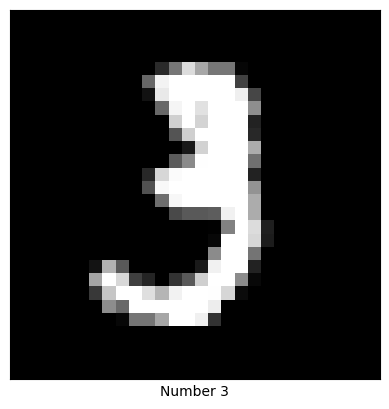

In [ ]:
plt.imshow(X_train[10,:,:], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.xlabel(class_names[y_train[10]])
plt.show()

In [ ]:
from typing import Optional
def plot_data(X_data: np.ndarray, y_data:np.ndarray, y_proba: Optional[np.ndarray] = None)->None:
  nrows, ncols = 2, 4
  fig, axes = plt.subplots(nrows, ncols, figsize=(10,6))

  len_x = X_data.shape[0]
  for idx in range(nrows*ncols):
    ax = axes[idx // ncols, idx % ncols]
    img_idx = random.randint(0, len_x)
    ax.imshow(X_data[img_idx], cmap='gray')
    ax.set(xticks=[], yticks=[])
    color = 'green'

    true_label_str = f"True: {class_names[y_data[img_idx]]}"

    if y_proba is not None:
      predicted_idx = np.argmax(y_proba[img_idx])
      predicted_label = class_names[predicted_idx]
      color = 'red' if predicted_idx != y_data[img_idx] else color
      predicted_label_str = f"\nPredicted: {predicted_label}"

    img_title = true_label_str if y_proba is None else true_label_str + predicted_label_str
    ax.set_xlabel(img_title, color=color, fontsize=12)

  plt.tight_layout()
  plt.show()

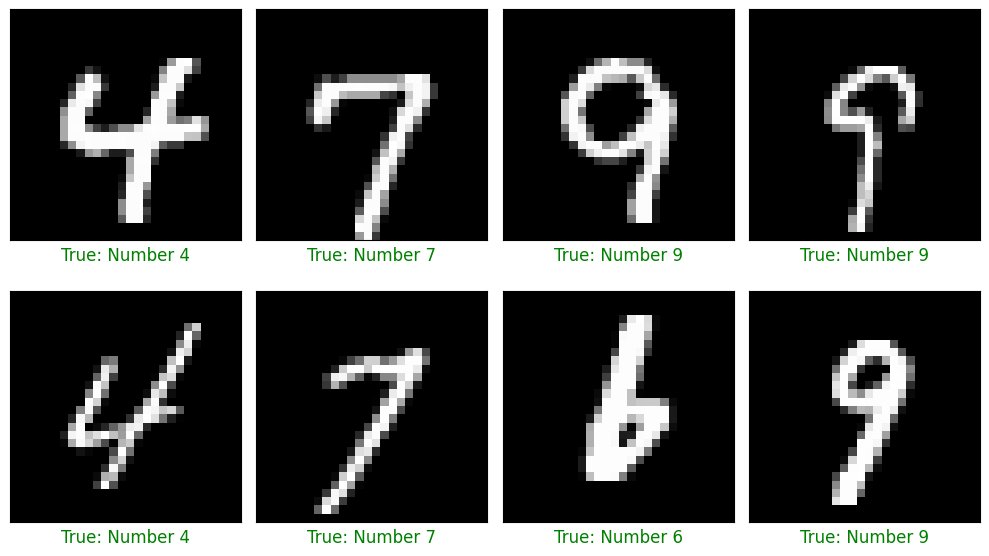

In [ ]:
plot_data(X_train, y_train)

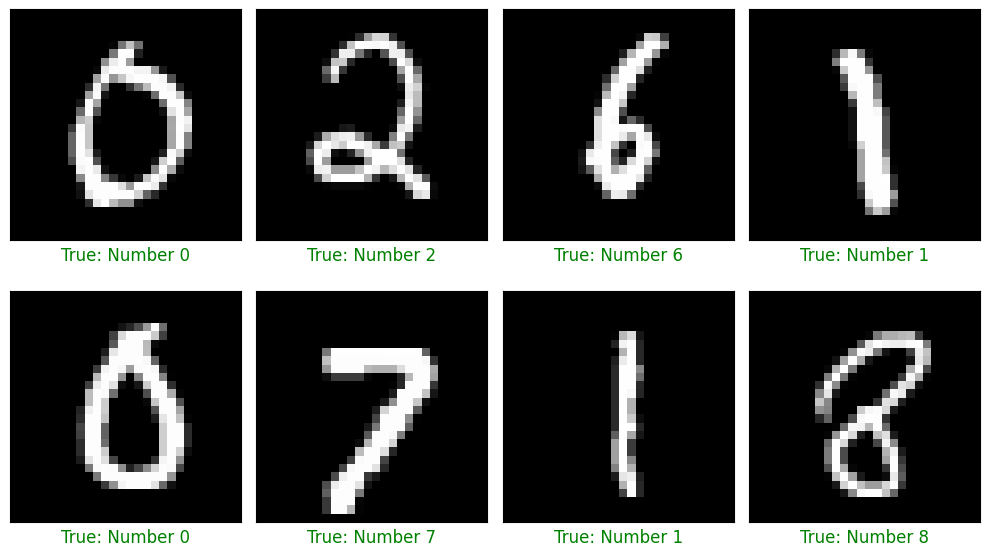

In [ ]:
plot_data(X_test, y_test)

#3. Image Pre-processing

In [ ]:
# Convert to float32 (tăng tốc quá trình tính toán) & scale images to the [0,1] range for training (giúp mô hình học tốt hơn)
# => cải thiện hiệu suất và tính ổn định của mô hình
X_train=X_train.astype(np.float32) / 255
X_test=X_test.astype(np.float32) / 255

In [ ]:
X_train.shape, X_train.dtype, type(X_train)

((60000, 28, 28), dtype('float32'), numpy.ndarray)

In [ ]:
X_test.shape, X_test.dtype, type(X_test)

((10000, 28, 28), dtype('float32'), numpy.ndarray)

In [ ]:
#Make sure images have shape (60000, 28, 28) => (60000, 28, 28, 1) (do dữ liệu của tensorflow thì có 4 thuộc tính: samples, height, width, channels)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [ ]:
X_train.shape, X_train.dtype, type(X_train)

((60000, 28, 28, 1), dtype('float32'), numpy.ndarray)

In [ ]:
X_test.shape, X_test.dtype, type(X_test)

((10000, 28, 28, 1), dtype('float32'), numpy.ndarray)

In [ ]:
#Tại sao phải đổi về dạng one-hot encoding: Phù hợp với softmax activation, Thuận lợi cho hàm mất mát categorical_crossentropy, Tạo ổn định cho quá trình học

y_train_label = keras.utils.to_categorical(y_train, class_nums)
y_test_label = keras.utils.to_categorical(y_test, class_nums)

In [ ]:
y_train[0], y_train_label[0]

(5, array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32))

#4. Network (CNN) Architecture

In [ ]:
input_shape = (28, 28, 1)

In [ ]:
# Tại sao dùng hàm softmax: biến các output thành các vector phân phối xác suất có tổng các xác suất = 1
# Tại sao dùng maxpooling mà không dùng average pooling: vì max-pooling mới làm nổi bật lên cái feature rõ ràng nhất, lấy được cái thông tin nổi bật nhất
# còn average-pooling thì nó tính trung bình các feature nên không lấy được các feature nổi bật nhất
# Tại sao chỉ cần dùng filter có kích thước nhỏ như 3*3: vì các cạnh trong ảnh được định nghĩa, tạo ra bởi các input gần nhau
# layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape, padding='valid', strides=(1,1)),

#Using CNN to predict
def create_CNN_model():
  model = keras.models.Sequential([
      layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
      layers.MaxPool2D(pool_size=(2,2)),
      layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
      layers.MaxPool2D(pool_size=(2,2)),
      layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
      layers.Flatten(),
      layers.Dense(128, activation='relu'), #lớp fully connected
      layers.Dense(class_nums, activation='softmax'),
  ])
  model.compile(optimizer='adam', #sử dụng thuật toán tối ưu hóa Adam để cập nhật trọng số của mô hình
                loss='categorical_crossentropy',
                metrics="accuracy")
  return model

In [ ]:
basic_CNN_model = create_CNN_model()

In [ ]:
basic_CNN_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 flatten_6 (Flatten)         (None, 1152)             

In [ ]:
import os
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

def call_back(checkpoint_path):
  early_stopping_callback = EarlyStopping(
      patience=10,  # Số epochs không có cải thiện trước khi dừng huấn luyện
      monitor='val_loss',  # Theo dõi giá trị validation loss để quyết định có cải thiện hay không
      restore_best_weights=True,  # Sau khi dừng, khôi phục trọng số của model tại epoch có validation loss tốt nhất
      verbose=1
  )
  checkpoint_callback = ModelCheckpoint(
      filepath=checkpoint_path,
      save_weights_only=True,  # Chỉ lưu trọng số, không lưu toàn bộ mô hình.
      monitor='val_loss',  # Theo dõi giá trị validation loss để quyết định khi nào lưu trọng số
      save_best_only=True,  # Chỉ lưu trọng số của mô hình có giá trị validation loss tốt nhất trên 'monitor'
      mode='min',  # Theo dõi theo chiều giảm của 'monitor'
      verbose=1  # Hiển thị thông báo khi lưu model
  )

  return early_stopping_callback, checkpoint_callback

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Colab_Notebooks/model_saver/basic_CNN_weight.cp"
early_stopping_callback, checkpoint_callback = call_back(checkpoint_path=checkpoint_path)

In [ ]:
epochs = 100
batch_size = 256

In [ ]:
history = basic_CNN_model.fit(X_train, y_train_label,
          epochs=epochs,
          batch_size=batch_size,
          validation_split=0.2,
          callbacks = [early_stopping_callback, checkpoint_callback]
          )

Epoch 1/100
187/188 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.9029
Epoch 1: val_loss did not improve from 0.03484
188/188 [==============================] - 3s 9ms/step - loss: 0.3375 - accuracy: 0.9031 - val_loss: 0.0959 - val_accuracy: 0.9718
Epoch 2/100
185/188 [============================>.] - ETA: 0s - loss: 0.0741 - accuracy: 0.9768
Epoch 2: val_loss did not improve from 0.03484
188/188 [==============================] - 2s 8ms/step - loss: 0.0739 - accuracy: 0.9768 - val_loss: 0.0656 - val_accuracy: 0.9808
Epoch 3/100
186/188 [============================>.] - ETA: 0s - loss: 0.0514 - accuracy: 0.9839
Epoch 3: val_loss did not improve from 0.03484
188/188 [==============================] - 2s 10ms/step - loss: 0.0513 - accuracy: 0.9840 - val_loss: 0.0506 - val_accuracy: 0.9843
Epoch 4/100
186/188 [============================>.] - ETA: 0s - loss: 0.0372 - accuracy: 0.9879
Epoch 4: val_loss did not improve from 0.03484
188/188 [=====================

In [ ]:
history_dict = history.history

In [ ]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
train_loss, val_loss = history_dict['loss'], history_dict['val_loss']
train_acc, val_acc = history_dict['accuracy'], history_dict['val_accuracy']

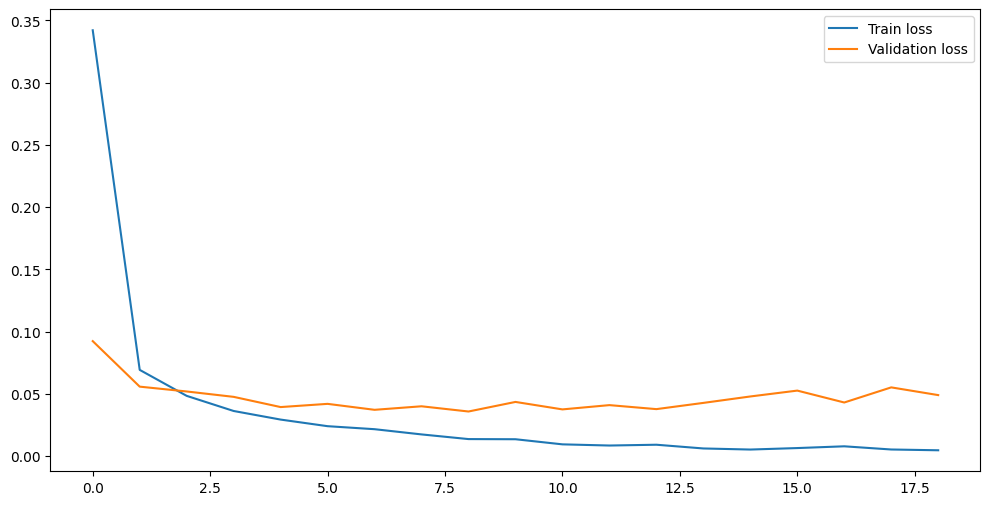

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

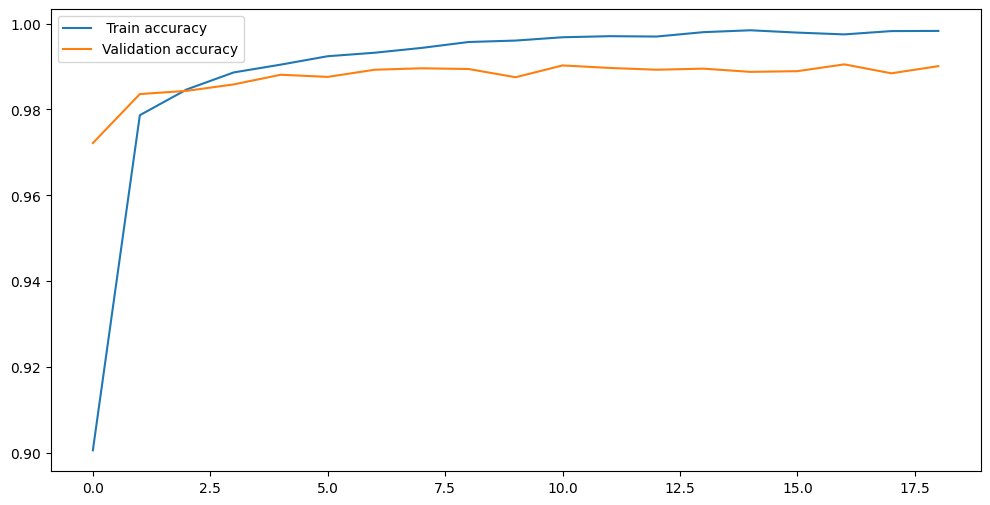

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label=' Train accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend()
plt.show()

#5. Model Evaluation

In [ ]:
best_model = create_CNN_model()
best_model.load_weights(checkpoint_path)
loss, acc = best_model.evaluate(X_test, y_test_label ,verbose=1)
print(f"Loss: {round(loss, 4)}\nAccuracy: {round(acc, 4)}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0246 - accuracy: 0.9919
Loss: 0.0246
Accuracy: 0.9919


In [ ]:
y_proba = best_model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [ ]:
X_simple=X_test[5]
X_simple=X_simple.reshape(1, X_simple.shape[0], X_simple.shape[1], X_simple.shape[2])
y_pred=best_model.predict(X_simple)
print(y_pred)
y_pred_idx=np.argmax(y_pred)
print(y_pred_idx)

1/1 [==============================] - 0s 66ms/step
[[1.09500256e-07 9.99991417e-01 1.27602632e-07 2.05012521e-10
  1.94354834e-06 5.91648552e-09 7.71834685e-09 6.20394667e-06
  1.11854355e-07 1.67629921e-07]]
1


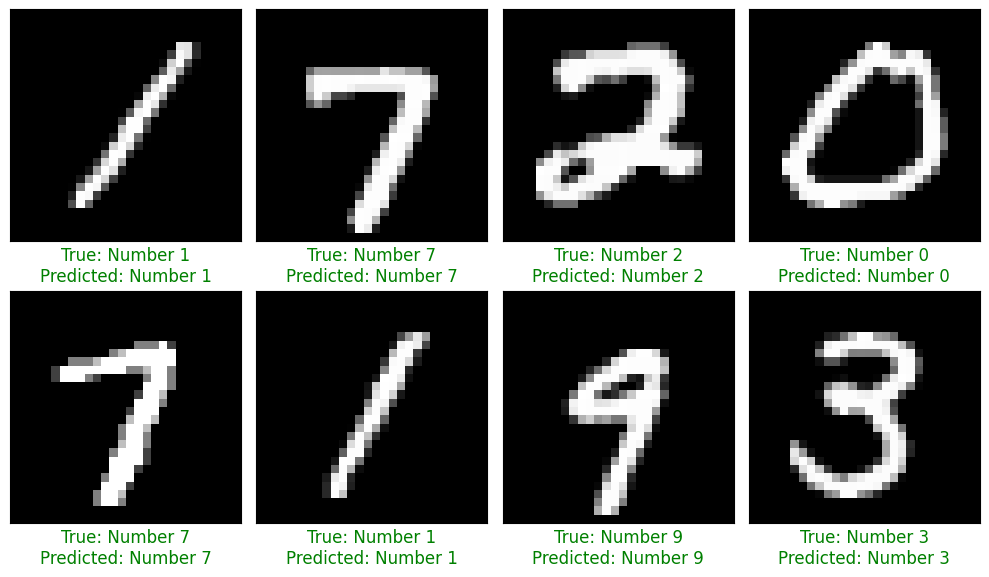

In [ ]:
plot_data(X_test, y_test, y_proba)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def calculate_metrics(y_true, y_pred):
    # Tính toán precision, recall và F1 cho từng nhãn
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)

    return precision, recall, f1

y_true_label = np.argmax(y_test_label, axis=1)
y_proba_label = np.argmax(y_proba, axis=1)

# Tính toán các chỉ số đánh giá hiệu suất
precision, recall, f1 = calculate_metrics(y_true_label, y_proba_label)

# In kết quả
print("Confussion Matrix: \n", confusion_matrix(y_true_label, y_proba_label),"\n")
for i in range(len(precision)):
    print(f"Label {i} - Precision: {precision[i]}, Recall: {recall[i]}, F1: {f1[i]}")


Confussion Matrix: 
 [[ 978    0    0    0    0    0    0    1    1    0]
 [   0 1129    0    1    0    0    1    4    0    0]
 [   1    0 1024    0    1    0    0    5    1    0]
 [   0    0    2 1006    0    2    0    0    0    0]
 [   0    1    0    1  974    0    0    1    0    5]
 [   2    0    1    7    0  880    1    0    0    1]
 [   3    2    0    0    3    1  948    0    1    0]
 [   0    1    1    0    0    0    0 1025    1    0]
 [   3    1    3    3    0    0    2    3  957    2]
 [   0    1    0    0    4    5    0    6    1  992]] 

Label 0 - Precision: 0.9908814589665653, Recall: 0.9979591836734694, F1: 0.9944077275038129
Label 1 - Precision: 0.9947136563876652, Recall: 0.9947136563876652, F1: 0.9947136563876652
Label 2 - Precision: 0.9932104752667313, Recall: 0.9922480620155039, F1: 0.9927290353853612
Label 3 - Precision: 0.9882121807465619, Recall: 0.996039603960396, F1: 0.9921104536489151
Label 4 - Precision: 0.9918533604887984, Recall: 0.9918533604887984, F1: 0.9918